<a href="https://colab.research.google.com/github/darthwaydr007/gan/blob/master/AdverserialTrained_AC_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import random
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU')
    device = torch.device("cpu")

There are 1 GPU available.
GPU: Tesla T4


In [2]:
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [3]:
BATCH_SIZE = 128
nc = 1
nz = 100
ngf = 64
ndf = 64
LR = 1e-3
CLASSES = 10
epsilon = 0.3

In [4]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.5), std=(0.5))
    ])

mnist_train = datasets.MNIST(root='/content/drive/My Drive/MNIST', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='/content/drive/My Drive/MNIST', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_train , batch_size = BATCH_SIZE, shuffle = True , drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test , batch_size = BATCH_SIZE , shuffle = False , drop_last=True)

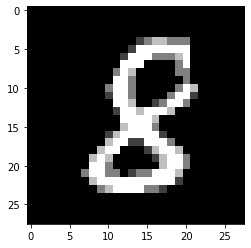

In [5]:
iterator = iter(train_loader)
images, labels = iterator.next()
plt.imshow(images[0].reshape(28, 28), cmap="gray")

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model_head = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf*4) x 4 x 4
        )

        self.classes = nn.Sequential(
            nn.Linear(ndf*4*4*4,CLASSES),
            nn.LogSoftmax()
        )
        self.disc = nn.Sequential(
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        out = self.model_head(input)
        flatten = out.view(-1 , ndf*4*4*4)
        disc = self.disc(out)
        classes = self.classes(flatten)
        return {
            'disc_output' : disc.cuda(),
            'disc_classes' : classes.cuda(),
            'features' : flatten.cuda()
        }

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        #self.emb = nn.Embedding(CLASSES, nz)
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 2, 2, 2, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.model(input).cuda()

In [8]:
mnist_dim = 784

In [9]:
G = Generator().to(device)
D = Discriminator().to(device)

In [10]:
def fgsm(img , epsilon , data_grad):
  new_image = img.cuda() + epsilon*data_grad.cuda().sign()
  new_image = torch.clamp(new_image, -1, 1)
  return new_image

In [11]:
def perturb_image(img , Model , label , GAN):
  #x = img.clone()
  img.requires_grad = True
  output = Model(img)
  if GAN == True:
    loss = criterion_aux(output['disc_classes'] , label)
  else:
    loss = criterion_aux(output , label)
  loss.backward()
  data_grad = img.grad.data
  Model.zero_grad()
  new_image = fgsm(x , epsilon , data_grad)
  return new_image

In [12]:
def D_train(x , label , train):
  x_real, y_real = x.view(BATCH_SIZE, nc, 28, 28).cuda(), torch.ones(BATCH_SIZE, 1).cuda()
  #z = torch.randn(BATCH_SIZE, nz, 1, 1).to(device)
  #fake_label = np.random.randint(0, 10, BATCH_SIZE)
  fake_label = torch.randint(10 , (BATCH_SIZE,)).cuda()
  onehot = torch.zeros(BATCH_SIZE, CLASSES)
  onehot[np.arange(BATCH_SIZE), fake_label] = 1
  noise = torch.randn(BATCH_SIZE, nz)
  noise[np.arange(BATCH_SIZE) , :CLASSES] = onehot[np.arange(BATCH_SIZE)]
  z = noise.view(BATCH_SIZE, nz, 1, 1).to(device)

    
  if train == True:
    G.train()
    D.train()
    D.zero_grad()

    # train discriminator on real
    x_fake, y_fake = G(z), torch.zeros(BATCH_SIZE, 1).to(device)

    data = D(x_real)
    D_output1_disc = data['disc_output']
    D_output1_aux = data['disc_classes']
    D_real_disc_loss = criterion_disc(D_output1_disc, y_real)
    D_real_aux_loss = criterion_aux(D_output1_aux , label)
    D_real_loss = D_real_disc_loss+D_real_aux_loss
    D_real_loss.backward()

    # train discriminator on facke
    data = D(x_fake)
    D_output2_disc = data['disc_output']
    D_output2_aux = data['disc_classes']
    D_fake_disc_loss = criterion_disc(D_output2_disc, y_fake)
    D_fake_aux_loss = criterion_aux(D_output2_aux, fake_label)
    D_fake_loss = D_fake_disc_loss+D_fake_aux_loss
    D_fake_loss.backward()

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    #D_loss.backward()
    D_optimizer.step()
    #print(D_output1_aux.shape)
    return {
        'loss' : D_loss.data.item() ,
        'output' : D_output1_aux
    }
  else:
    D.eval()
    data = D(x_real)
    D_output1_disc = data['disc_output']
    D_output1_aux = data['disc_classes']
    return {
        'loss' : D_output1_disc ,
        'output' : D_output1_aux
    }


In [13]:
def D_train_adverserial(x , label , train):
  x_real, y_real = x.view(BATCH_SIZE, nc, 28, 28).cuda(), torch.ones(BATCH_SIZE, 1).cuda()
  fake_label = torch.randint(10 , (BATCH_SIZE,)).cuda()
  onehot = torch.zeros(BATCH_SIZE, CLASSES)
  onehot[np.arange(BATCH_SIZE), fake_label] = 1
  noise = torch.randn(BATCH_SIZE, nz)
  noise[np.arange(BATCH_SIZE) , :CLASSES] = onehot[np.arange(BATCH_SIZE)]
  z = noise.view(BATCH_SIZE, nz, 1, 1).to(device) 
  if train == True:
    G.train()
    D.train()
    D.zero_grad()

    # train discriminator on real
    x_fake, y_fake = G(z), torch.zeros(BATCH_SIZE, 1).to(device)
    img = x_real.clone()
    x_perturb = perturb_image(img , D , label , GAN = True)

    data = D(x_real)
    D_output1_disc = data['disc_output']
    D_output1_aux = data['disc_classes']
    D_real_disc_loss = criterion_disc(D_output1_disc, y_real)
    D_real_aux_loss = criterion_aux(D_output1_aux , label)
    D_real_loss = D_real_disc_loss+D_real_aux_loss
    #D_real_loss = D_real_loss*0.5
    #
    D_real_loss.backward(retain_graph = True)
    
    data = D(x_perturb)
    D_output1_discP = data['disc_output']
    D_output1_auxP = data['disc_classes']
    D_real_disc_lossP = criterion_disc(D_output1_discP, y_real)
    D_real_aux_lossP = criterion_aux(D_output1_auxP , label)
    D_real_lossP = D_real_disc_lossP+D_real_aux_lossP
    #D_real_lossP = D_real_lossP*0.5
    D_real_lossP.backward()

    D_real_clasf_loss = D_real_aux_lossP + D_real_aux_loss
    # train discriminator on fake
    
    data = D(x_fake)
    D_output2_disc = data['disc_output']
    D_output2_aux = data['disc_classes']
    D_fake_disc_loss = criterion_disc(D_output2_disc, y_fake)
    D_fake_aux_loss = criterion_aux(D_output2_aux, fake_label)
    D_fake_loss = D_fake_disc_loss+D_fake_aux_loss
    D_fake_loss.backward()

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_aux_lossP + D_real_aux_loss
    #D_loss.backward()
    D_optimizer.step()
    #print(D_output1_aux.shape)
    return {
        'loss' : D_real_clasf_loss.data.item() ,
        'outputP' : D_output1_auxP,
        'output' : D_output1_aux
    }
  else:
    D.train()
    data = D(x_real)
    D_output1_disc = data['disc_output']
    D_output1_aux = data['disc_classes']
    return {
        'loss' : D_output1_disc ,
        'output' : D_output1_aux
    }


In [14]:
def G_train(label):
    G.train()
    D.train()
    G.zero_grad()

    #z = torch.randn(BATCH_SIZE, nz, 1, 1).to(device)
    #fake_label = torch.randint(10 , (BATCH_SIZE,))
    onehot = torch.zeros(BATCH_SIZE, CLASSES)
    onehot[np.arange(BATCH_SIZE), label] = 1
    noise = torch.randn(BATCH_SIZE, nz)
    noise[np.arange(BATCH_SIZE) , :CLASSES] = onehot[np.arange(BATCH_SIZE)]
    z = noise.view(BATCH_SIZE, nz, 1, 1).to(device)

    y0 = torch.ones(BATCH_SIZE, 1).cuda()

    G_output = G(z)
    data = D(G_output)
    D_output_disc = data['disc_output']
    D_output_aux = data['disc_classes']
    G_disc_loss = criterion_disc(D_output_disc, y0)
    G_aux_loss = criterion_aux(D_output_aux , label)
    G_loss = G_disc_loss+G_aux_loss

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
    G.zero_grad()
        
    return G_loss.data.item() , G_output

In [15]:
def display_grid(images):
    grid_img = torchvision.utils.make_grid(images , nrow=8)
    npimgs = grid_img.cpu().detach().numpy()
    npimgs = npimgs*0.5+0.5
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='gray')
    plt.show()

In [16]:
Accuracy_Clasf_train = []
Accuracy_Clasf_test = []
Accuracy_Clasf_FGSM = []

Accuracy_GAN_train = []
Accuracy_GAN_test = []
Accuracy_GAN_FGSM = []

In [17]:
n_epoch = 20

In [18]:

criterion_disc = nn.BCELoss()
criterion_aux = nn.NLLLoss()
D_optimizer = optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


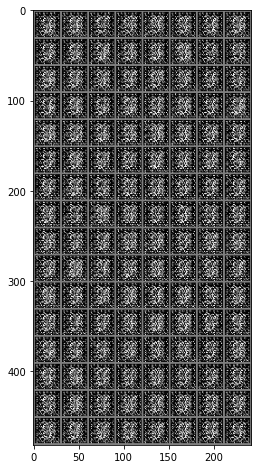

[1/20]: loss_d: 1.987, loss_g: 7.220
Accuracy Training regular:  0.8429
Accuracy Training adv:  0.578
Accuracy Testing :  0.8911
Accuracy FGSM:  0.6479


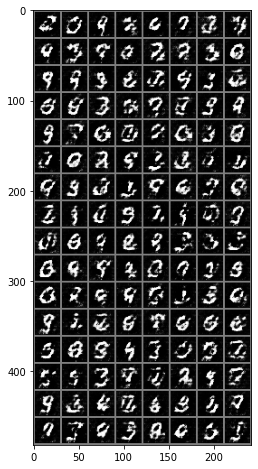

[2/20]: loss_d: 1.741, loss_g: 6.005
Accuracy Training regular:  0.9137
Accuracy Training adv:  0.7039
Accuracy Testing :  0.9402
Accuracy FGSM:  0.7671


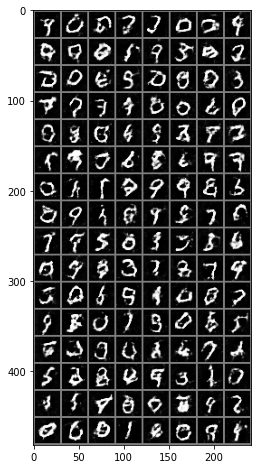

[3/20]: loss_d: 1.582, loss_g: 5.354
Accuracy Training regular:  0.9461
Accuracy Training adv:  0.774
Accuracy Testing :  0.9596
Accuracy FGSM:  0.8077


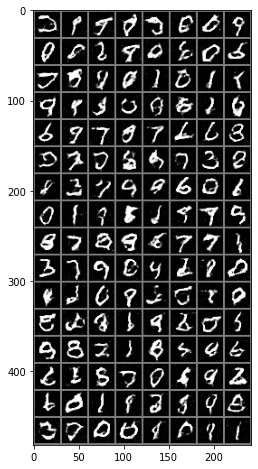

[4/20]: loss_d: 1.480, loss_g: 5.020
Accuracy Training regular:  0.9603
Accuracy Training adv:  0.8056
Accuracy Testing :  0.9673
Accuracy FGSM:  0.8309


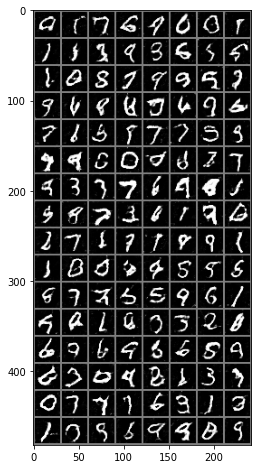

[5/20]: loss_d: 1.408, loss_g: 4.813
Accuracy Training regular:  0.9654
Accuracy Training adv:  0.829
Accuracy Testing :  0.9721
Accuracy FGSM:  0.8543


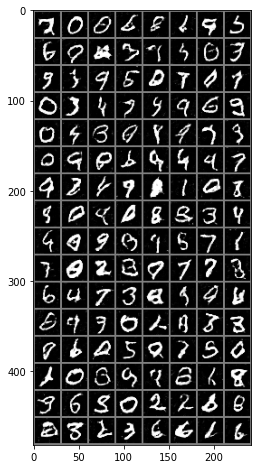

[6/20]: loss_d: 1.356, loss_g: 4.672
Accuracy Training regular:  0.968
Accuracy Training adv:  0.8432
Accuracy Testing :  0.9726
Accuracy FGSM:  0.8625


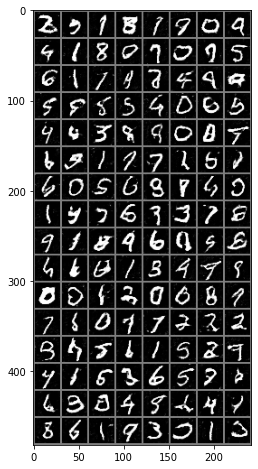

[7/20]: loss_d: 1.318, loss_g: 4.569
Accuracy Training regular:  0.9706
Accuracy Training adv:  0.8505
Accuracy Testing :  0.9736
Accuracy FGSM:  0.8656


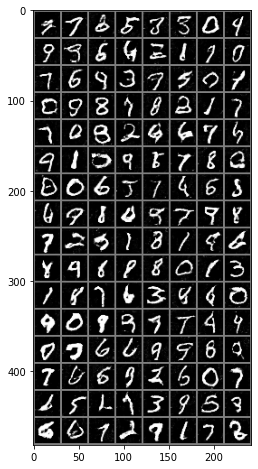

[8/20]: loss_d: 1.288, loss_g: 4.500
Accuracy Training regular:  0.9725
Accuracy Training adv:  0.8562
Accuracy Testing :  0.9759
Accuracy FGSM:  0.8692


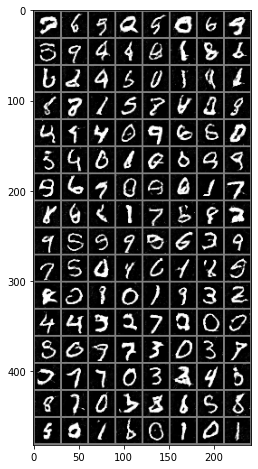

[9/20]: loss_d: 1.264, loss_g: 4.449
Accuracy Training regular:  0.9733
Accuracy Training adv:  0.8613
Accuracy Testing :  0.9745
Accuracy FGSM:  0.8731


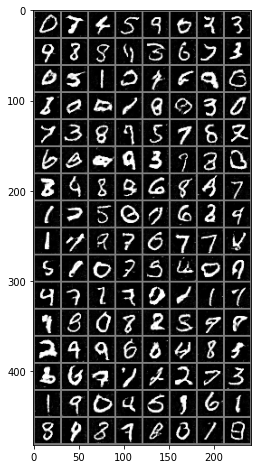

[10/20]: loss_d: 1.244, loss_g: 4.414
Accuracy Training regular:  0.9745
Accuracy Training adv:  0.8654
Accuracy Testing :  0.9754
Accuracy FGSM:  0.8777


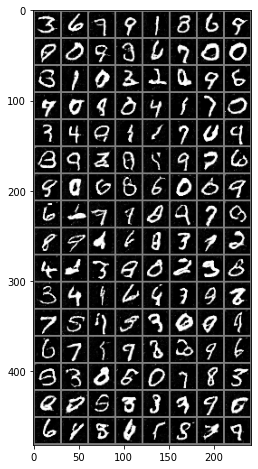

[11/20]: loss_d: 1.229, loss_g: 4.390
Accuracy Training regular:  0.9752
Accuracy Training adv:  0.8663
Accuracy Testing :  0.9775
Accuracy FGSM:  0.8753


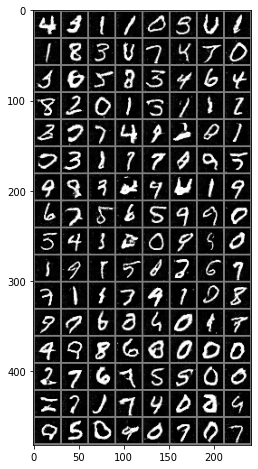

[12/20]: loss_d: 1.215, loss_g: 4.377
Accuracy Training regular:  0.9757
Accuracy Training adv:  0.8705
Accuracy Testing :  0.9775
Accuracy FGSM:  0.8726


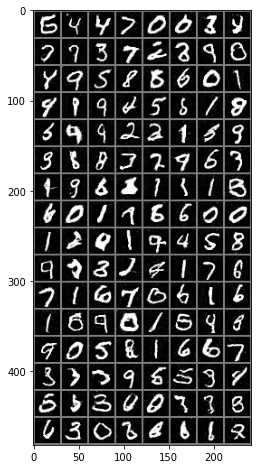

[13/20]: loss_d: 1.203, loss_g: 4.368
Accuracy Training regular:  0.9774
Accuracy Training adv:  0.8735
Accuracy Testing :  0.9795
Accuracy FGSM:  0.8699


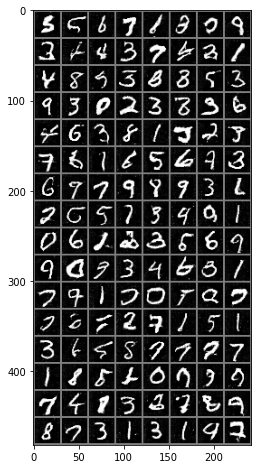

[14/20]: loss_d: 1.192, loss_g: 4.364
Accuracy Training regular:  0.9779
Accuracy Training adv:  0.8753
Accuracy Testing :  0.9781
Accuracy FGSM:  0.8654


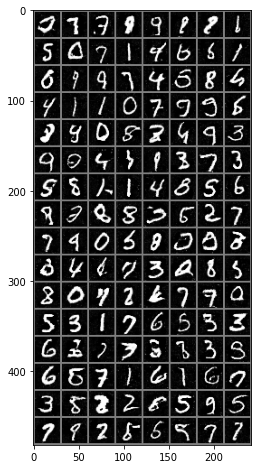

[15/20]: loss_d: 1.182, loss_g: 4.361
Accuracy Training regular:  0.9781
Accuracy Training adv:  0.8765
Accuracy Testing :  0.9799
Accuracy FGSM:  0.879


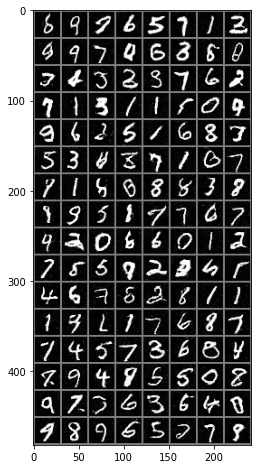

[16/20]: loss_d: 1.174, loss_g: 4.360
Accuracy Training regular:  0.9786
Accuracy Training adv:  0.8792
Accuracy Testing :  0.9798
Accuracy FGSM:  0.8613


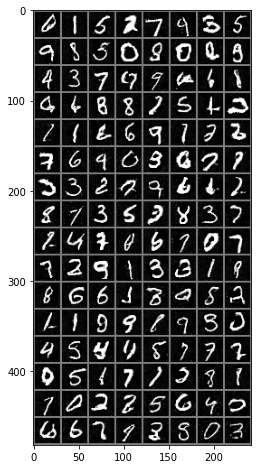

[17/20]: loss_d: 1.166, loss_g: 4.361
Accuracy Training regular:  0.9789
Accuracy Training adv:  0.8801
Accuracy Testing :  0.9789
Accuracy FGSM:  0.88


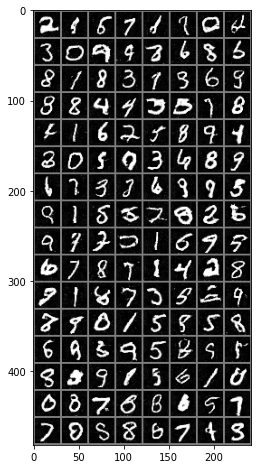

[18/20]: loss_d: 1.159, loss_g: 4.363
Accuracy Training regular:  0.9797
Accuracy Training adv:  0.8829
Accuracy Testing :  0.98
Accuracy FGSM:  0.8618


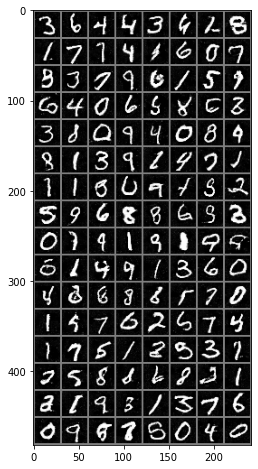

[19/20]: loss_d: 1.153, loss_g: 4.367
Accuracy Training regular:  0.9799
Accuracy Training adv:  0.8839
Accuracy Testing :  0.9797
Accuracy FGSM:  0.8869


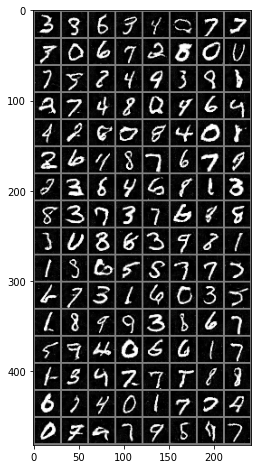

[20/20]: loss_d: 1.147, loss_g: 4.372
Accuracy Training regular:  0.9803
Accuracy Training adv:  0.8862
Accuracy Testing :  0.9813
Accuracy FGSM:  0.8356


In [19]:

D_losses, G_losses = [], []
for epoch in range(1, n_epoch+1):
    #if epoch % 10 == 0:
    #  LR = LR//2
    correct = 0
    total = 0    
    correct1 = 0
    total1 = 0
        #=======================Train=======================#
    for batch_idx, (x, label) in enumerate(train_loader):
        #d  = D_train(x , label.cuda() , train = True)
        d  = D_train_adverserial(x , label.cuda() , train = True)
        d_loss = d['loss']
        output = d['output']
        outputP = d['outputP']
        
        g_loss , g_images= G_train(label.cuda())
        D_losses.append(d_loss)
        G_losses.append(g_loss)

        for idx ,i in enumerate(output):
          if torch.argmax(i) == label[idx]:
            correct += 1
          total += 1
        
        for idx ,i in enumerate(outputP):
          if torch.argmax(i) == label[idx]:
            correct1 += 1
          total1 += 1

        if batch_idx % 250 == 0 and not batch_idx == 0:# and epoch % 3 == 0:
          #print(label.size(0))
          g_images = g_images.resize(BATCH_SIZE,1,28,28)
          display_grid(g_images)
          #display_grid(x)
          #print('D(X) : {:}   || D(G(Z)) : {:}'.format(d_loss , g_loss))
    Accuracy_GAN_train.append(correct/total)
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    print('Accuracy Training regular: ' , round(correct/total , 4))
    print('Accuracy Training adv: ' , round(correct1/total1 , 4))
    correct = 0
    total = 0
    #=======================Test=======================#
    with torch.no_grad():
      for batch_idx, (x, label) in enumerate(test_loader):
          d  = D_train_adverserial(x , label.cuda() , train = False)
          output = d['output']
          for idx ,i in enumerate(output):
            if torch.argmax(i) == label[idx]:
              correct += 1
            total += 1
      Accuracy_GAN_test.append(correct/total)
      print('Accuracy Testing : ' , round(correct/total , 4))
    #=======================Adverserial Test=======================# 
    correct = 0
    total = 0
    D.eval()
    for batch_idx, (x, label) in enumerate(test_loader):

      x = x.view(BATCH_SIZE, nc, 28, 28).cuda()
      x.requires_grad = True
      data = D(x)
      output = data['disc_classes']
      loss = criterion_aux(output , label.cuda())
      #D_output1 = data['disc_fearures']
      #output = classifier(D_output1)
      #loss = criterion1(output , label.cuda())
      D.zero_grad()
      loss.backward()
      data_grad = x.grad.data
      with torch.no_grad():
        new_img = fgsm(x , epsilon , data_grad)
        data = D(new_img)
        new_output = data['disc_classes']
        #new_output1 = new_data['disc_fearures']
        #new_output = classifier(new_output1)

        for idx , i in enumerate(new_output):
          if torch.argmax(i) == label[idx]:
            correct += 1
          total += 1
    Accuracy_GAN_FGSM.append(correct/total)
    print("Accuracy FGSM: " , round(correct/total , 4))


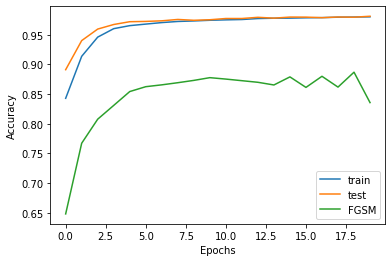

In [20]:
x1 = Accuracy_GAN_train
x2 = Accuracy_GAN_test
x3 = Accuracy_GAN_FGSM
plt.plot(x1  , label = 'train')
plt.plot(x2  ,  label = 'test')
plt.plot(x3 ,  label = 'FGSM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_head = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf*4) x 4 x 4
        )

        self.classes = nn.Sequential(
            nn.Linear(ndf*4*4*4,CLASSES),
            nn.LogSoftmax()
        )
    def forward(self, input):
        out = self.model_head(input)
        flatten = out.view(-1 , ndf*4*4*4)
        classes = self.classes(flatten)
        return classes.cuda()

In [22]:
classifier = MNISTClassifier().to(device)
optimizer = optim.Adam(classifier.parameters(), lr = LR , betas=(0.5, 0.999))

In [23]:

epochs = []
for epoch in range(0, n_epoch): 
    #if epoch % 10 == 0:
    #  LR = LR//10
    epochs.append(epoch)
    #=======================Train=======================#
    classifier.train()
    correct = 0
    total = 0
    correct1 = 0
    total1 = 0
    print('======== Epoch {:} / {:} ========'.format(epoch+1, n_epoch))          
    #D_losses, G_losses = [], []
    for batch_idx, (x, label) in enumerate(train_loader):
        with torch.autograd.set_detect_anomaly(True):
          optimizer.zero_grad()
          x_real = x.view(BATCH_SIZE, nc, 28, 28).cuda()
          img = x_real.clone()
          #adverserial trainig  
          x_perturb = perturb_image(img , classifier , label.cuda() , GAN = False)
          output1 = classifier(x_perturb)
          loss = criterion_aux(output1 , label.cuda())
          loss.backward()
             
          output = classifier(x_real)
          loss1 = criterion_aux(output , label.cuda())
          loss1.backward(retain_graph=True)
          optimizer.step()

        for idx ,i in enumerate(output1):
          if torch.argmax(i) == label[idx]:
            correct1 += 1
          total1 += 1

          
        for idx ,i in enumerate(output):
          if torch.argmax(i) == label[idx]:
            correct += 1
          total += 1

        if batch_idx % 750 == 0 and not batch_idx == 0: 
          g_images = new_img.resize(BATCH_SIZE,1,28,28)
          display_grid(g_images)
          print('|| loss : {:} '.format(new_loss.mean().item())) 

    Accuracy_Clasf_train.append(correct/total)
    print('Accuracy Training regular: ' , round(correct/total , 4))
    print('Accuracy Training adv: ' , round(correct1/total1 , 4))
    #=======================Test=======================#    
    correct = 0
    total = 0
    classifier.eval()
    with torch.no_grad():
      for batch_idx, (x, label) in enumerate(test_loader):
        x_real = x.view(BATCH_SIZE, nc, 28, 28).cuda()
        output = classifier(x_real)
        for idx ,i in enumerate(output):
          if torch.argmax(i) == label[idx]:
            correct += 1
          total += 1
    Accuracy_Clasf_test.append(correct/total)
    print('Accuracy Testing : ' , round(correct/total , 4))
    #=======================Adverserial Test=======================# 
    correct = 0
    total = 0
    classifier.eval()
    for batch_idx, (x, label) in enumerate(test_loader):

      x = x.view(BATCH_SIZE, nc, 28, 28).cuda()
      img = x.clone()
      new_img = perturb_image(img , classifier , label.cuda() , GAN = False)
      new_output = classifier(new_img)
      

      for idx , i in enumerate(new_output):
        if torch.argmax(i) == label[idx]:
          correct += 1
        total += 1
    Accuracy_Clasf_FGSM.append(correct/total)
    print("Accuracy FGSM: " , round(correct/total , 4))

======== Epoch 1 / 20 ========


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy Training regular:  0.9358
Accuracy Training adv:  0.8488
Accuracy Testing :  0.9762
Accuracy FGSM:  0.9361
======== Epoch 2 / 20 ========
Accuracy Training regular:  0.9801
Accuracy Training adv:  0.9427
Accuracy Testing :  0.9853
Accuracy FGSM:  0.955
======== Epoch 3 / 20 ========
Accuracy Training regular:  0.9858
Accuracy Training adv:  0.9548
Accuracy Testing :  0.9868
Accuracy FGSM:  0.96
======== Epoch 4 / 20 ========
Accuracy Training regular:  0.9892
Accuracy Training adv:  0.9625
Accuracy Testing :  0.988
Accuracy FGSM:  0.9624
======== Epoch 5 / 20 ========
Accuracy Training regular:  0.9909
Accuracy Training adv:  0.9674
Accuracy Testing :  0.9884
Accuracy FGSM:  0.968
======== Epoch 6 / 20 ========
Accuracy Training regular:  0.9923
Accuracy Training adv:  0.9709
Accuracy Testing :  0.99
Accuracy FGSM:  0.9684
======== Epoch 7 / 20 ========
Accuracy Training regular:  0.9938
Accuracy Training adv:  0.9739
Accuracy Testing :  0.9891
Accuracy FGSM:  0.9688
======== 

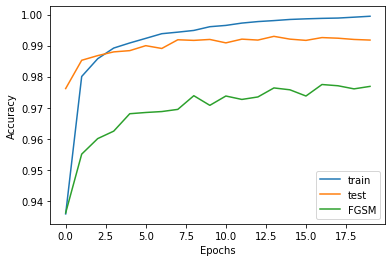

In [24]:
x1 = Accuracy_Clasf_train
x2 = Accuracy_Clasf_test
x3 = Accuracy_Clasf_FGSM
plt.plot(x1  , label = 'train')
plt.plot(x2  ,  label = 'test')
plt.plot(x3  ,  label = 'FGSM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()